In [19]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder


df = sns.load_dataset("titanic")

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [10]:
df['deck'].unique()

[NaN, 'C', 'E', 'G', 'D', 'A', 'B', 'F']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [ ]:
# 결측치 확인
print(df.isnull().sum())

# 결측치 처리 (평균 or 최빈값 or 중위값)

ss = StandardScaler()
le = LabelEncoder()
oe = OneHotEncoder()

# 파생변수 생성
df['age_group'] = pd.cut(df['age'], bins=[0, 16, 20, 50, 100], labels=['Teen', 'Young', 'Adults', 'Senior'])
df['no_companion'] = df['sibsp'] + df['parch']
df['average_per_family'] = df['fare'] / (df['no_companion'] + 1)


# 연속형 범주형 분리
num_col = ['age', 'fare', 'no_companion', 'average_per_family']
cat_col = ['sex', 'pclass' , 'embarked', 'class', 'who', 'deck', 'embark_town' , 'alone', 'age_group']

# 불필요한 콜럼 제거
X = df.drop(['survived', 'alive', 'adult_male', 'sibsp','parch'], axis=1)
y = df['survived']

# 결측치 처리
si = SimpleImputer(strategy="mean")
X['age'] = si.fit_transform(X[['age']])

si = SimpleImputer(strategy="most_frequent")
X['deck'] = si.fit_transform(X[['deck']]).squeeze()
X['embark_town'] = si.fit_transform(X[['embark_town']]).squeeze()



# 수치형 컬럼 처리
X[num_col] = ss.fit_transform(X[num_col])

    #연속형 컬럼 처리
for col in cat_col:
        X[col] = le.fit_transform(X[col])


X.head()



survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


,pclass,sex,age,fare,embarked,class,who,deck,embark_town,alone,age_group,no_companion,average_per_family
0,2,1,-0.592481,-0.502445,2,2,1,2,2,0,0,0.059160,-0.454798
1,0,0,0.638789,0.786845,0,0,2,2,0,0,0,0.059160,0.438994
2,2,0,-0.284663,-0.488854,2,2,2,2,2,1,0,-0.560975,-0.334757
3,0,0,0.407926,0.420730,2,0,2,2,2,0,0,0.059160,0.185187
4,2,1,0.407926,-0.486337,2,2,1,2,2,1,0,-0.560975,-0.331267


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 테스트와 훈련용으로 구분
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 적용
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)

# 반올림 처리
train_acc = round(random_forest.score(X_train, y_train)*100, 2)
test_acc = round(random_forest.score(X_test, y_test)*100, 2)
print(f"훈련의 정확도 {train_acc}")
print(f"테스트의 정확도 {test_acc}")

# 테스트의 정확도가 훨씬 많이 떨어지는 것이 보임

훈련의 정확도 98.46
테스트의 정확도 81.56


Top 3 Important Variables:  ['age', 'sex', 'average_per_family']


<function matplotlib.pyplot.show(close=None, block=None)>

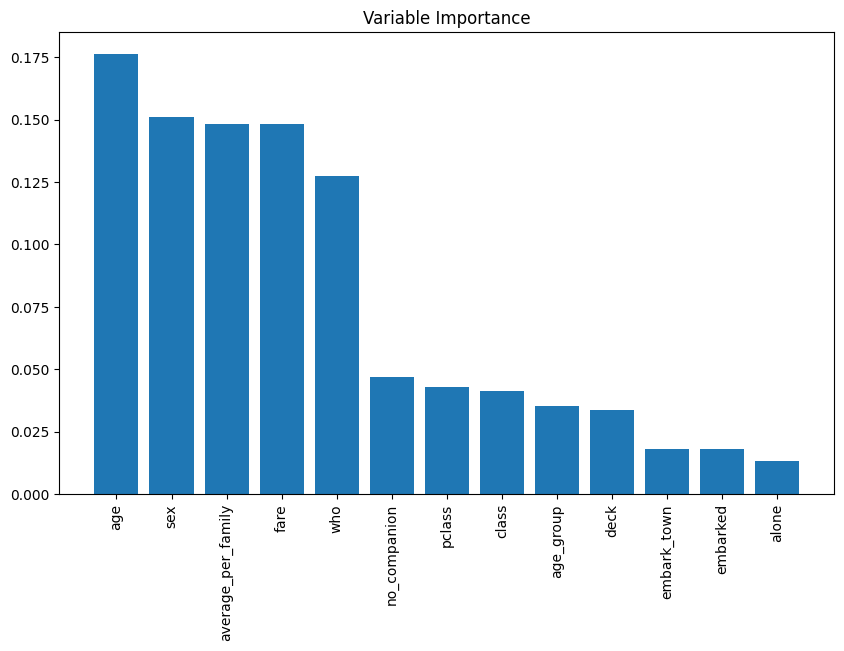

In [32]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
importances = random_forest.feature_importances_

#중요도를 내림차순으로 배열
var_importance = np.argsort(importances)[::-1]

# 중요도가 제일 높은 변수 상위 3개
top_3 = [X_train.columns[i] for i in var_importance[:3]]
print("Top 3 Important Variables: ", top_3)

#시각화
plt.figure(figsize=(10,6))
plt.title("Variable Importance")
plt.bar(range(X_train.shape[1]), importances[var_importance], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[var_importance], rotation=90)
plt.tight_layout
plt.show

In [47]:
# 하이퍼 파라미터 튜닝
# grid search는 정해진 값들을 사용해서 가장 최적의 조합을 찾아내는 방식
param_grid = {
    'n_estimators' : [50, 100, 200, 1000], # 예측 안정화를 위해 값을 늘려봄
    'max_depth' : [None, 5, 10, 15], # 트리의 복잡도를 조정해 최적의 예측을 할 수 있도록 함
    'min_samples_leaf' : [1, 2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1', cv=3,  n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}


In [ ]:
# 가장 좋은 값을 가진 튜닝으로 모델 예측
best_model = grid_search.best_estimator_
y_pred = random_forest.predict(X_test)
tuned_y_pred = best_model.predict(X_test)


# 값이 차이가 미미하지만 오히려 조금 줄어든 모습을 보임. 하지만 0.001 이내의 차이라 무의미한 차이라고 봐도 무방함
print(f"Before Tuning - Accuracy : {accuracy_score(y_test, y_pred)}, F1 Score: {f1_score(y_test, y_pred, average='macro')}")
print(f"After Tuning - Accuracy : {accuracy_score(y_test, tuned_y_pred)}, F1 Score: {f1_score(y_test, tuned_y_pred, average='macro')}")

Before Tuning - Accuracy : 0.8156424581005587, F1 Score: 0.8013585768571141
After Tuning - Accuracy : 0.8100558659217877, F1 Score: 0.7918035030103996


오버피팅: 훈련과 테스트의 정확도 혹은 f1 스코어 차이 --> 학습 데이터에 과하게 적합됨
방지할 수 있는 방법:
1. 정규화 --> logistic regression의 l1, l2 규제 등
2. 교차검증: 데이터를 여러번 나누어 평균 성능을 측정 --> 시도할 방법
3. 특성 제한 --> 불필요한 노이즈 제거

In [ ]:
from sklearn.model_selection import cross_val_score

#교차 검증 적용
cv_score = cross_val_score(best_model, X_test, y_test, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy의 평균: " , np.mean(cv_score))

# 교차 검증을 통해 정확성이 조금 더 높아진 것을 확인할 수 있음.

Cross-Validation Accuracy의 평균:  0.7655555555555555


실제 활용 가능성 분석:
- 해당 모델은 높은 정확도와 f1 score를 보이기 때문에 실제 활용 가능 할 석으로 예상됩니다


모델 성능을 높이기 위한 추가적인 데이터 수집
- 개인에 대한 조금 더 퍼스널한 데이터가 있었으면 더 높은 성능을 보일 것으로 예상됩니다 --> 운동 등
- 